<a href="https://colab.research.google.com/github/Carlosrnes/DMDSAA/blob/master/CNN/CNN_Fine_Tuning_Transfer_Learning_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

https://colab.research.google.com/notebooks/gpu.ipynb

In [1]:
!nvidia-smi

Fri Apr  8 08:46:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### How to Load Kaggle Datasets Directly into Google Colab?

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download data
! kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [00:34<00:00, 148MB/s]
100% 5.30G/5.30G [00:34<00:00, 167MB/s]


### Libraries

In [4]:
import os, shutil, random
import numpy as np
import datetime
import zipfile

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image

###  Get Data

In [5]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("food41.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
# select the directory of the images (divided by class folder) - without data augmentation
data_folder = '/content/images'

list_class = os.listdir(data_folder)
list_class.sort()


print(f'{len(list_class)} Classes of foods.')
print(list_class)

101 Classes of foods.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',

### Data Preprocessing

In [7]:
# Set the seed
tf.random.set_seed(42)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# train set - generation
train_generator = tf.keras.preprocessing.image_dataset_from_directory(data_folder,
                                         image_size = IMAGE_SHAPE,
                                         batch_size = BATCH_SIZE,
                                         validation_split = 0.2,
                                         label_mode = 'categorical',
                                         seed=42,
                                         subset = 'training')

val_generator = tf.keras.preprocessing.image_dataset_from_directory(data_folder,
                                      image_size = IMAGE_SHAPE,
                                      batch_size = BATCH_SIZE,
                                      validation_split = 0.2,
                                      label_mode = 'categorical',
                                      seed=42,
                                      subset = 'validation')

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [8]:
# Check
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 101)


### Creating a callback

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Plot function

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Model 1 - Feature extraction model based on EfficientNetB0 with data augmentation 

In [ ]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # remove for EfficientNet, keep for ResNet50V2 and others                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Setup checkpoint path
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
feature_extraction_data_aug = model_1.fit(train_generator,
                                          epochs=initial_epochs,
                                          validation_data=val_generator,
                                          validation_steps=len(val_generator),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "model_data_aug"), 
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_data_aug/20220331-175744
Epoch 1/5
2525/2525 [==============================] - ETA: 0s - loss: 2.1693 - accuracy: 0.4735
Epoch 1: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 750s 290ms/step - loss: 2.1693 - accuracy: 0.4735 - val_loss: 1.5811 - val_accuracy: 0.5881
Epoch 2/5
2525/2525 [==============================] - ETA: 0s - loss: 1.6946 - accuracy: 0.5686
Epoch 2: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 524s 207ms/step - loss: 1.6946 - accuracy: 0.5686 - val_loss: 1.4795 - val_accuracy: 0.6137
Epoch 3/5
2525/2525 [==============================] - ETA: 0s - loss: 1.5814 - accuracy: 0.5948
Epoch 3: saving model to model_checkpoints_weights/checkpoint.ckpt
2525/2525 [==============================] - 476s 188ms/step - loss: 1.5814 - accuracy: 0.5948 - val_loss: 1.4326 - val_accuracy: 0.6272
Epoch 4/5
2525/

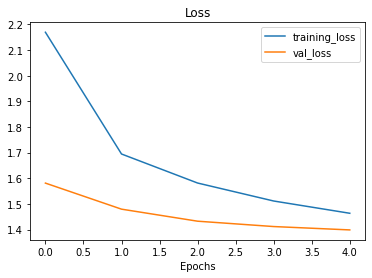

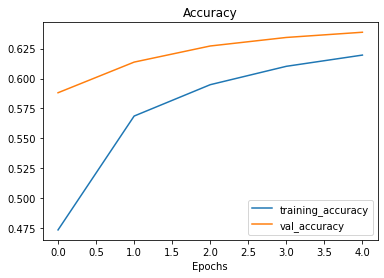

In [ ]:
# Plot model loss curves
plot_loss_curves(feature_extraction_data_aug)

In [ ]:
# Load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)
loaded_weights_model_results = model_1.evaluate(val_generator)

632/632 [==============================] - 81s 127ms/step - loss: 1.3986 - accuracy: 0.6387


In [ ]:
# Layers in loaded model
model_1.layers

In [ ]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Model 2 - Feature extracting and fine-tuning EfficientNetB0 with data augmentation

In [ ]:
base_model.trainable = True

# Freeze all layers except for the 10 last
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_1 except with more trainable layers)
model_fine_data_aug = model_1.fit(train_generator,
                                  epochs=fine_tune_epochs,
                                  validation_data=val_generator,
                                  initial_epoch=feature_extraction_data_aug.epoch[-1], # start from previous last epoch
                                  validation_steps=len(val_generator),
                                  callbacks=[create_tensorboard_callback("transfer_learning", "fine_tune_feature_extracting")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/fine_tune_feature_extracting/20220331-184418
Epoch 5/10
2525/2525 [==============================] - 458s 178ms/step - loss: 1.3303 - accuracy: 0.6498 - val_loss: 1.3215 - val_accuracy: 0.6599
Epoch 6/10
2525/2525 [==============================] - 442s 175ms/step - loss: 1.2247 - accuracy: 0.6763 - val_loss: 1.2811 - val_accuracy: 0.6688
Epoch 7/10
2525/2525 [==============================] - 439s 174ms/step - loss: 1.1436 - accuracy: 0.6939 - val_loss: 1.2669 - val_accuracy: 0.6758
Epoch 8/10
2525/2525 [==============================] - 438s 173ms/step - loss: 1.0909 - accuracy: 0.7051 - val_loss: 1.2570 - val_accuracy: 0.6802
Epoch 9/10
2525/2525 [==============================] - 435s 172ms/step - loss: 1.0408 - accuracy: 0.7182 - val_loss: 1.2571 - val_accuracy: 0.6817
Epoch 10/10
2525/2525 [==============================] - 435s 172ms/step - loss: 0.9985 - accuracy: 0.7278 - val_loss: 1.2407 - val_accuracy: 0.6866


In [ ]:
# Function compares two model history objects

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.4735024869441986, 0.5686386227607727, 0.5948390960693359, 0.6101980209350586, 0.6195791959762573, 0.6497772336006165, 0.6762871146202087, 0.6938737630844116, 0.705123782157898, 0.718168318271637, 0.7277598977088928]


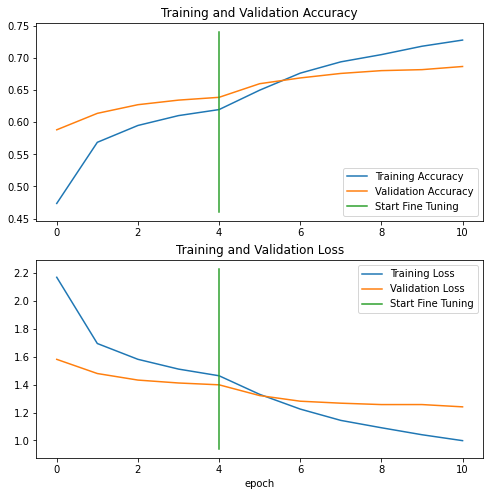

In [ ]:
compare_historys(original_history=feature_extraction_data_aug, 
                 new_history=model_fine_data_aug, 
                 initial_epochs=5)

### Save the model

In [ ]:
# # Save model so it can be used later 
model_1.save("/content/model_tf/model_EfficientNetB0_FineTuning", save_format='h5')

### Load the model

In [25]:
# Load Model
model = tf.keras.models.load_model("model_EfficientNetB0_FineTuning")

In [10]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(val_generator)
loaded_loss, loaded_accuracy

632/632 [==============================] - 96s 133ms/step - loss: 1.2407 - accuracy: 0.6866


(1.2406803369522095, 0.6866336464881897)

### Making predictions

In [11]:
# Get the class names
class_names = val_generator.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [12]:
# Make predictions with model
pred_probs = model.predict(val_generator, verbose=1)

632/632 [==============================] - 89s 134ms/step


In [13]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(val_generator)
loaded_loss, loaded_accuracy

632/632 [==============================] - 84s 132ms/step - loss: 1.2407 - accuracy: 0.6866


(1.2406810522079468, 0.6866336464881897)

In [14]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

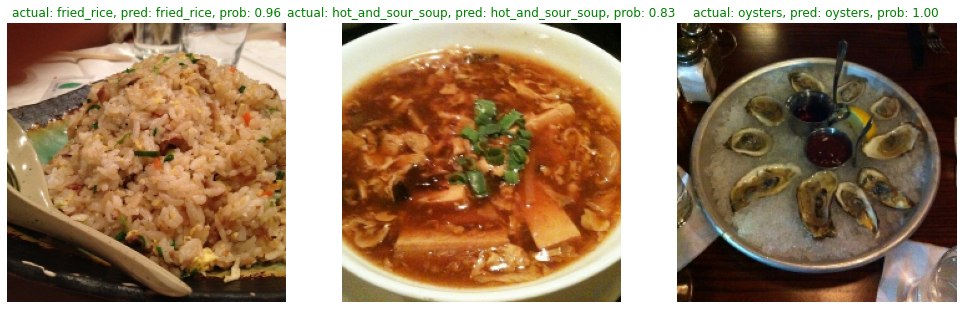

In [15]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir("/content/images/" + class_name))
  filepath = "/content/images/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Test out the model

In [16]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Get custom food images filepaths
custom_food_images = ["/content/drive/MyDrive/DL Photo Data/epicurious.com/" + img_path for img_path 
                      in os.listdir("/content/drive/MyDrive/DL Photo Data/epicurious.com")]
custom_food_images

['/content/drive/MyDrive/DL Photo Data/epicurious.com/MochiDonuts_HERO_030322_29243.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/Passionfruit-Curd_HERO_031622_29557.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/WhiteCurryVegetableSoup_RECIPE_121621_25675.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/22-FilledPasta.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/GemCakes_HERO_031821_10783.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/ColdOvenPoundcake_HERO_030322_28895.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/PullmanPan_HERO_IG_102721_389.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/HongKongEggTarts_RECIPE_IG_031722_30182.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/Melon-Pan_HERO_031622_29454.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/Basbousa.jpg',
 '/content/drive/MyDrive/DL Photo Data/epicurious.com/HoneyBuns_HERO_021622_28331.jpg',
 '/content/drive/

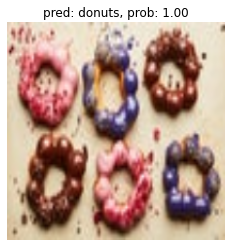

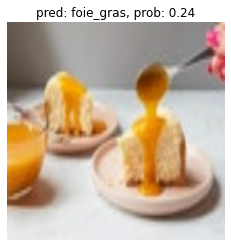

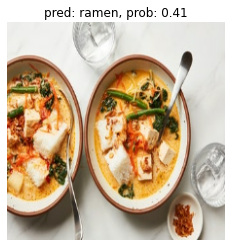

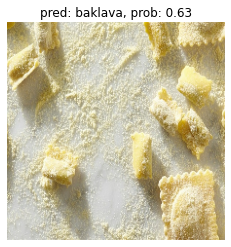

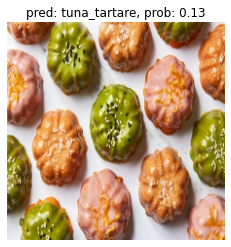

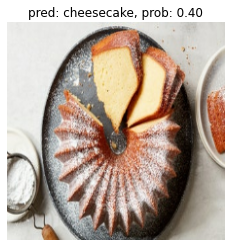

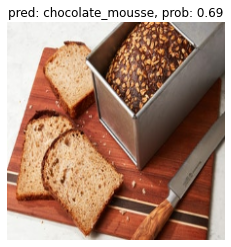

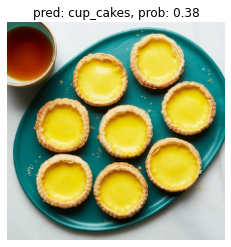

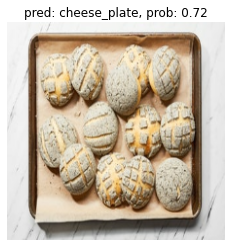

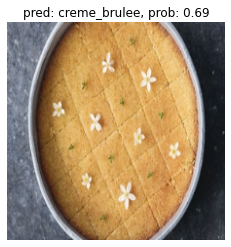

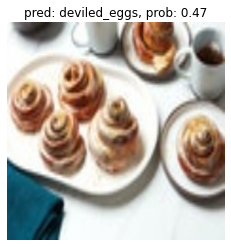

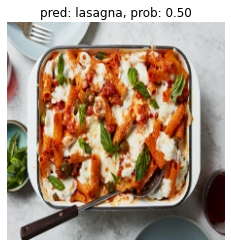

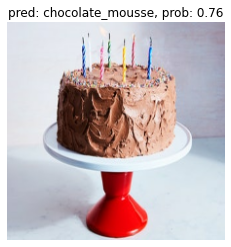

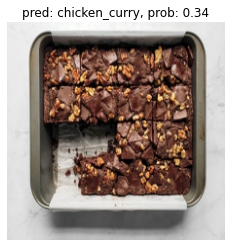

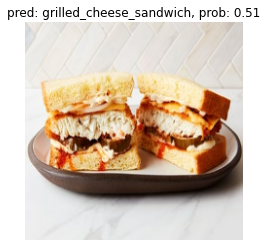

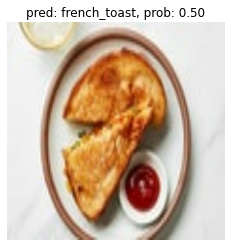

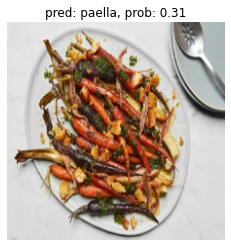

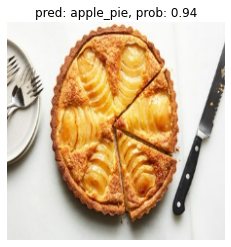

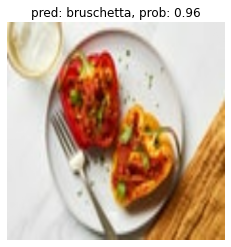

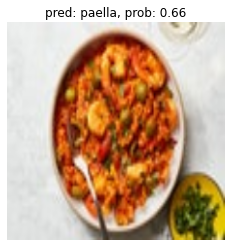

In [22]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)